# Table Generation

Notebook to validate method for table parsing and detection using MSER.

## Imports and Utility Functions

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import ceil

In [2]:
def plot_matrix(mat, cmap, points=None, rect=None, lines=None):
    height, width, *_ = mat.shape
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis("off")
    ax.imshow(mat, cmap=cmap)

    if points is not None:
        for point in points:
            ax.scatter(*point, color="red", s=50)
    
    if rect is not None:
        for (top_left_x, top_left_y, rect_width, rect_height) in rect:
            rect_patch = patches.Rectangle((top_left_x, top_left_y), rect_width, rect_height, linewidth=1, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect_patch)
    
    if lines is not None:
        for (start_x, start_y, end_x, end_y) in lines:
            ax.plot([start_x, end_x], [start_y, end_y], color='blue')
    
    plt.show()

In [3]:
def hough_to_cartesian(lines, img_shape, orientation='both', angle_threshold=1):
    """
    Convert Hough lines to Cartesian coordinates and filter by orientation.
    
    Parameters:
    lines: numpy.ndarray - Lines from cv2.HoughLines()
    img_shape: tuple - Shape of the image (height, width)
    orientation: str - 'vertical', 'horizontal', or 'both'
    angle_threshold: float - Maximum angle deviation from vertical/horizontal (in degrees)
    
    Returns:
    list - Filtered lines in format [(x1, y1, x2, y2), ...]
    """
    if lines is None:
        return []
        
    cartesian_lines = []
    for line in lines:
        rho, theta = line[0]
        
        # Convert theta to degrees for easier angle comparison
        angle_deg = np.degrees(theta)
        
        # Normalize angle to 0-180 degrees
        if angle_deg < 0:
            angle_deg += 180
            
        # For vertical lines, angle will be close to 0 or 180 degrees
        # For horizontal lines, angle will be close to 90 degrees
        is_vertical = angle_deg < angle_threshold or angle_deg > (180 - angle_threshold)
        is_horizontal = (90 - angle_threshold) <= angle_deg <= (90 + angle_threshold)
        
        # Filter based on orientation
        should_include = (
            (orientation == 'vertical' and is_vertical) or
            (orientation == 'horizontal' and is_horizontal) or
            (orientation == 'both')
        )
        
        if should_include:
            # Convert to Cartesian coordinates
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho

            x1 = max(ceil(x0 + img_shape[1] * np.round(-b, 3)), 0)
            y1 = ceil(y0 + img_shape[0] * np.round(a, 3))
            x2 = ceil(x0 - img_shape[1] * np.round(-b, 3))
            y2 = ceil(y0 - img_shape[0] * np.round(a, 3))

            cartesian_lines.append((x1, y1, x2, y2))
            
    return cartesian_lines

## Assessing MSER on Sectra Table

In [4]:
header = cv.imread("../mock/sectra_table_header.png", cv.IMREAD_COLOR)
firstrow = cv.imread("../mock/sectra_table_firstrow.png", cv.IMREAD_COLOR)
table = cv.imread("../mock/sectra_reportlist.png", cv.IMREAD_COLOR)

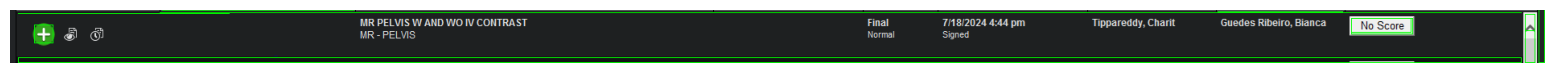

In [5]:
mser = cv.MSER_create()
regions, _ = mser.detectRegions(firstrow)
for p in regions:
    xmax, ymax = np.amax(p, axis=0)
    xmin, ymin = np.amin(p, axis=0)
    cv.rectangle(firstrow, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
    
plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(cv.cvtColor(firstrow, cv.COLOR_BGR2RGB))
plt.show()

## Detecting Rows and Columns on Sectra Table

Columns: Use horizontal pixel projection values to assess where the columns begin by looking at the 
Canny edge processed version

Rows: Use the hough transform to find the lines closest to the edges of the first row bounding box

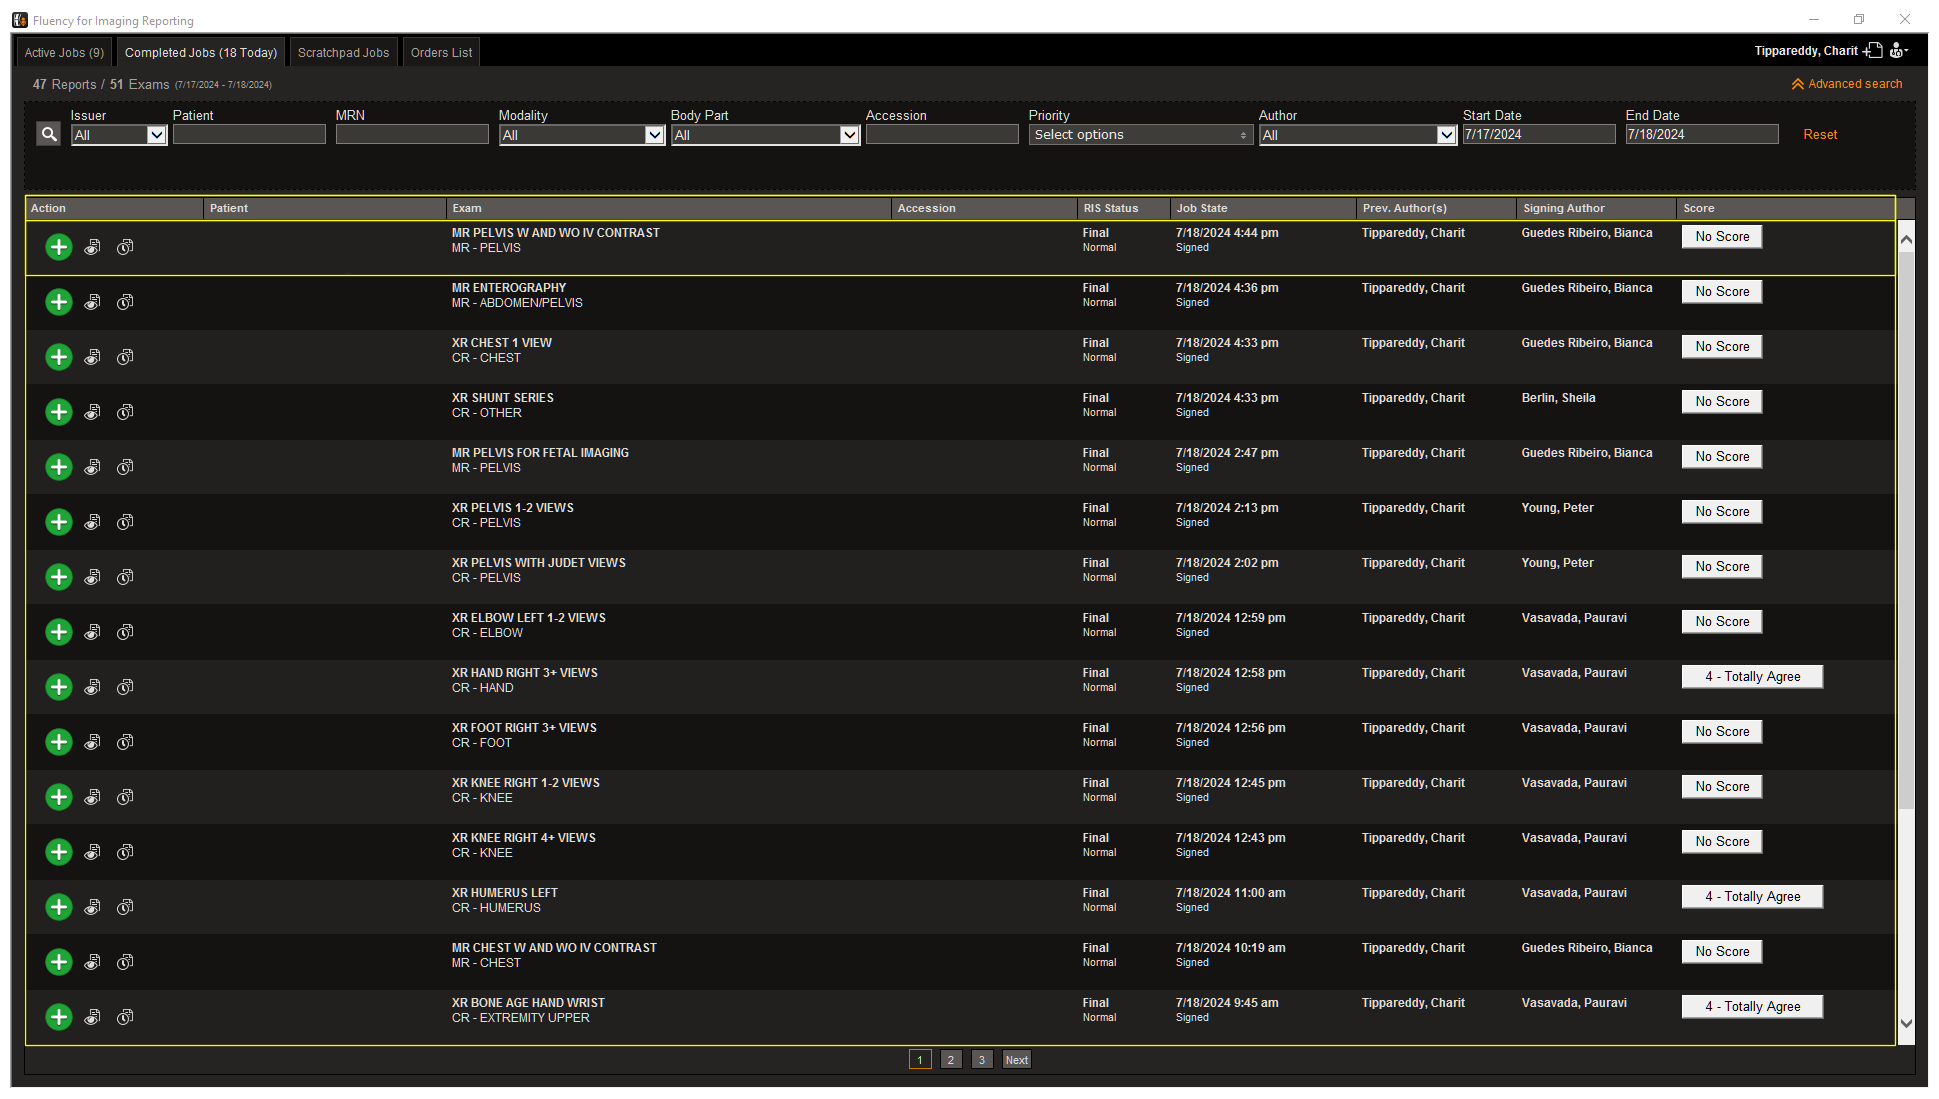

In [6]:
header_bounds = (15, 185, 1870, 25)
firstrow_bounds = (15, 210, 1870, 55)
scroll_bounds = (15, 185, 1870, 850)

plot_matrix(table, "gray", rect=[header_bounds, firstrow_bounds, scroll_bounds])

### Columns

Using pixel projection we can add up the pixel values for each column and then use methods to find
local minima if you plot the pixel intensities as a wave - identify the local minima before the next peak

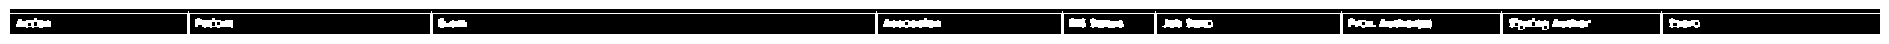

In [7]:
kernel = np.ones((3, 3), np.uint8)
y, x, height, width = header_bounds
header_edges = cv.Canny(table[x:x+width, y:y+height], 50, 100)
header_edges = cv.morphologyEx(header_edges, cv.MORPH_CLOSE, kernel)
plot_matrix(header_edges, "gray")

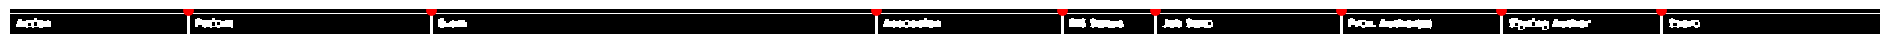

In [8]:
vpp = np.sum(header_edges, axis=0)
thresh = np.percentile(vpp, 99)
peaks = np.argwhere(vpp > thresh).flatten()
plot_matrix(header_edges, "gray", points=[(int(x), 0) for x in peaks])

In [9]:
header_bounds

(15, 185, 1870, 25)

In [10]:
def find_columns(img, bounds, cell_min_width = 50):
    x, y, width, height = bounds
    header = img[y:y+height, x:x+width]
    header_edges = cv.Canny(header, 50, 100)
    header_edges = cv.morphologyEx(header_edges, cv.MORPH_CLOSE, kernel)
    vpp = np.sum(header_edges, axis=0)
    thresh = np.percentile(vpp, 99)
    peaks = np.argwhere(vpp > thresh).flatten()

    # Add start and end points if the image did not grab them
    if peaks[0] > cell_min_width:
        peaks = np.insert(peaks, 0, 0) 
    if peaks[-1] < width - cell_min_width:
        peaks = np.append(peaks, width)

    columns = np.array([(int(peak_x + x), y, int(peak_x + x), img.shape[0]) for peak_x in peaks])

    # ensure sorted from left to right
    columns = columns[columns[:, 0].argsort()]
    return columns

[[  15  185   15 1080]
 [ 193  185  193 1080]
 [ 436  185  436 1080]
 [ 881  185  881 1080]
 [1067  185 1067 1080]
 [1160  185 1160 1080]
 [1346  185 1346 1080]
 [1506  185 1506 1080]
 [1666  185 1666 1080]
 [1885  185 1885 1080]]


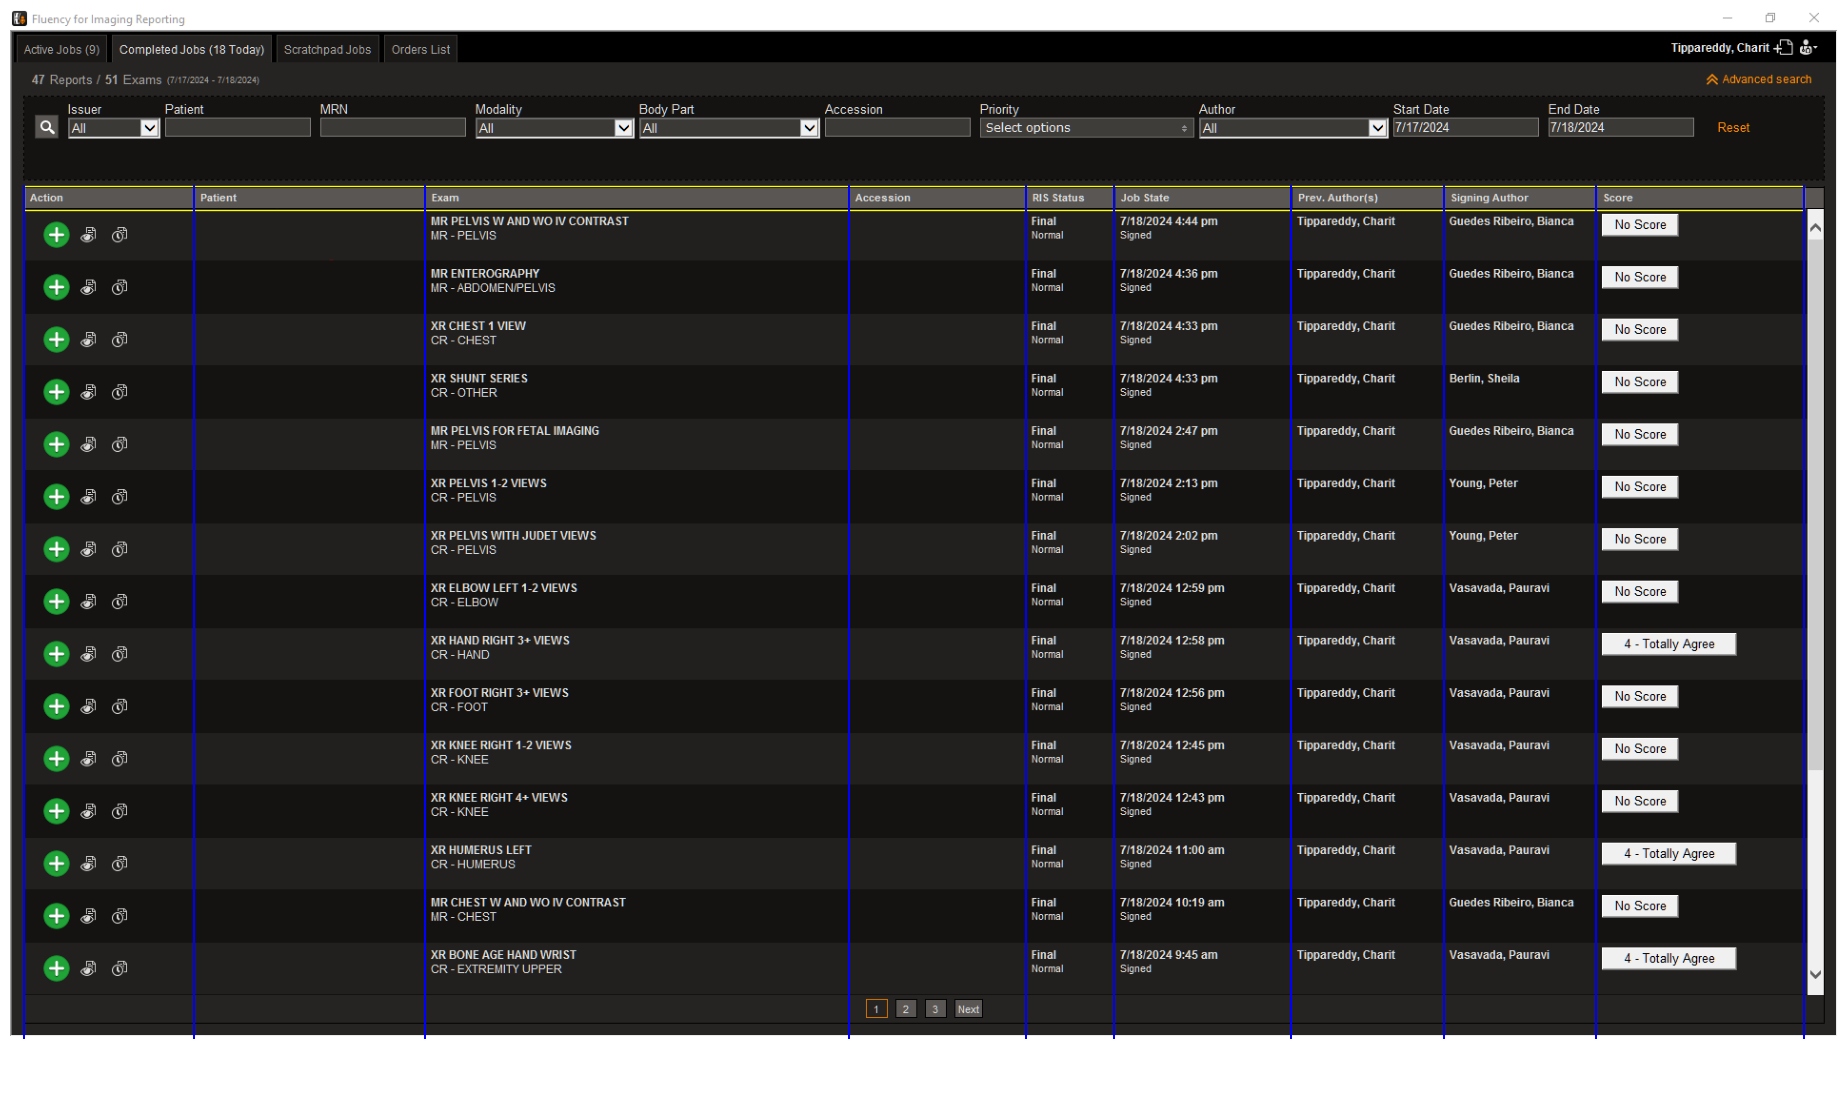

In [11]:
lines = find_columns(table, header_bounds)
print(lines)
plot_matrix(table, "gray", rect=[header_bounds], lines=lines)

### Rows

Using Hough Transform with the predefined header row in order to extract the rows of the table

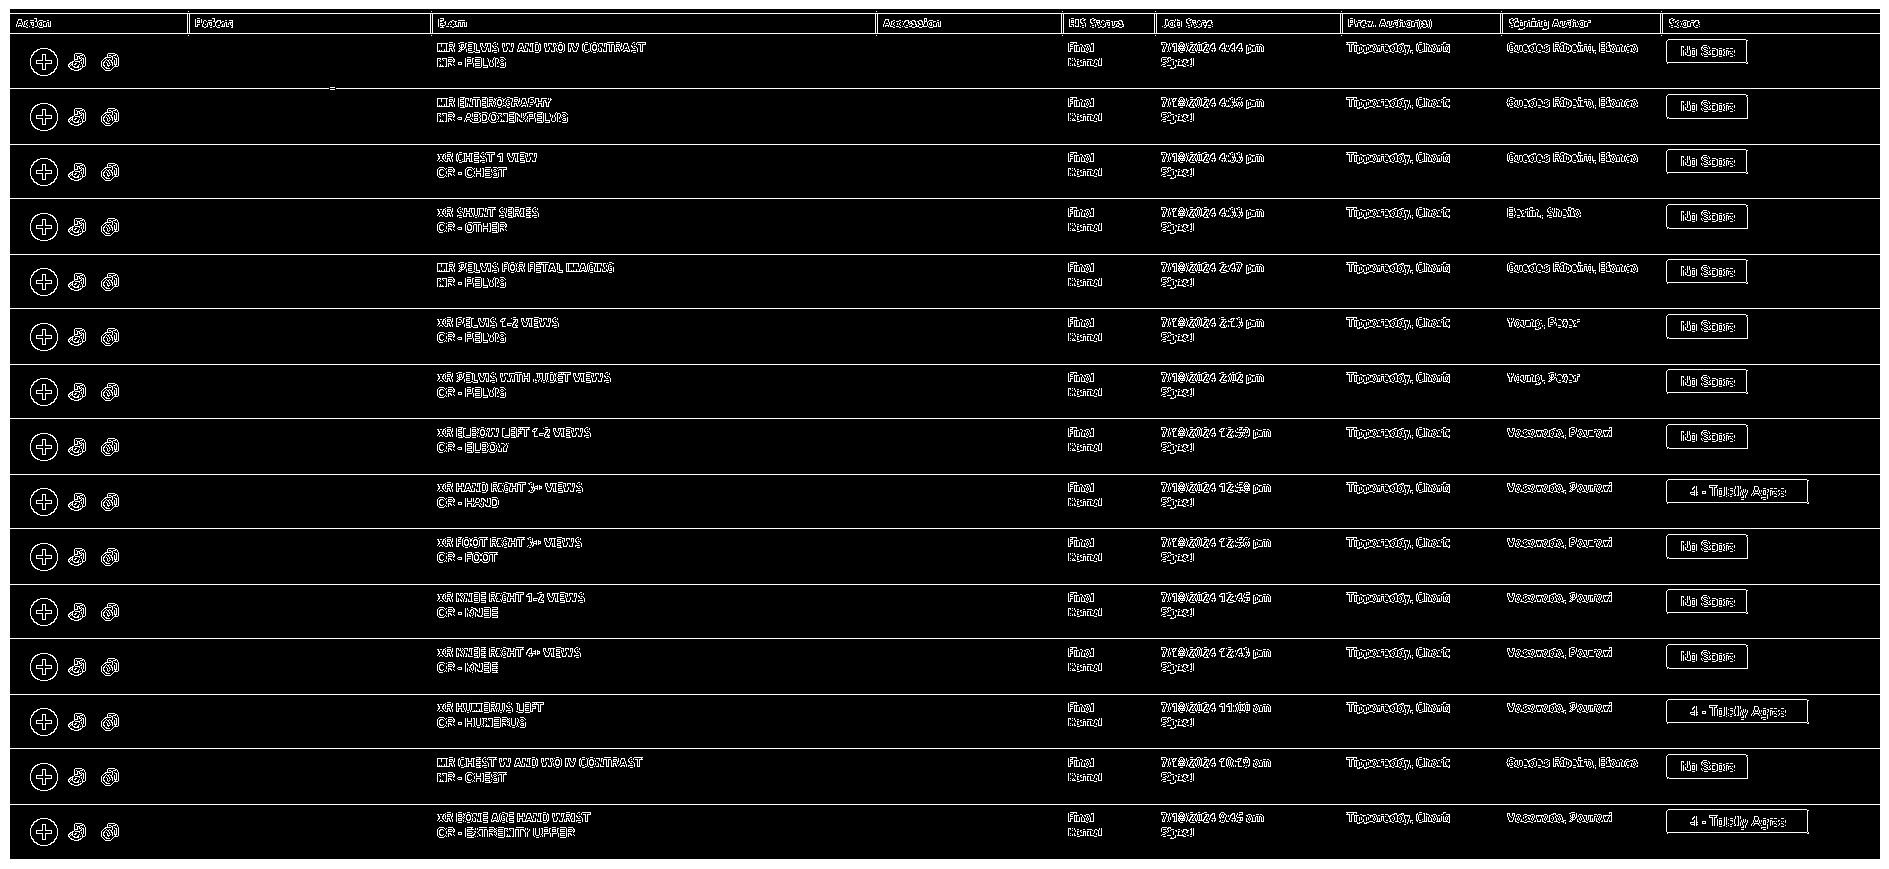

In [12]:
scy, scx, sc_height, sc_width = scroll_bounds
y, x, height, width = firstrow_bounds
scroll_area = table[scx:scx+sc_width, scy:scy+sc_height]
firstrow = table[x:x+width, y:y+height]
scroll_edges = cv.Canny(scroll_area, 0, 50)
plot_matrix(scroll_edges, "gray")

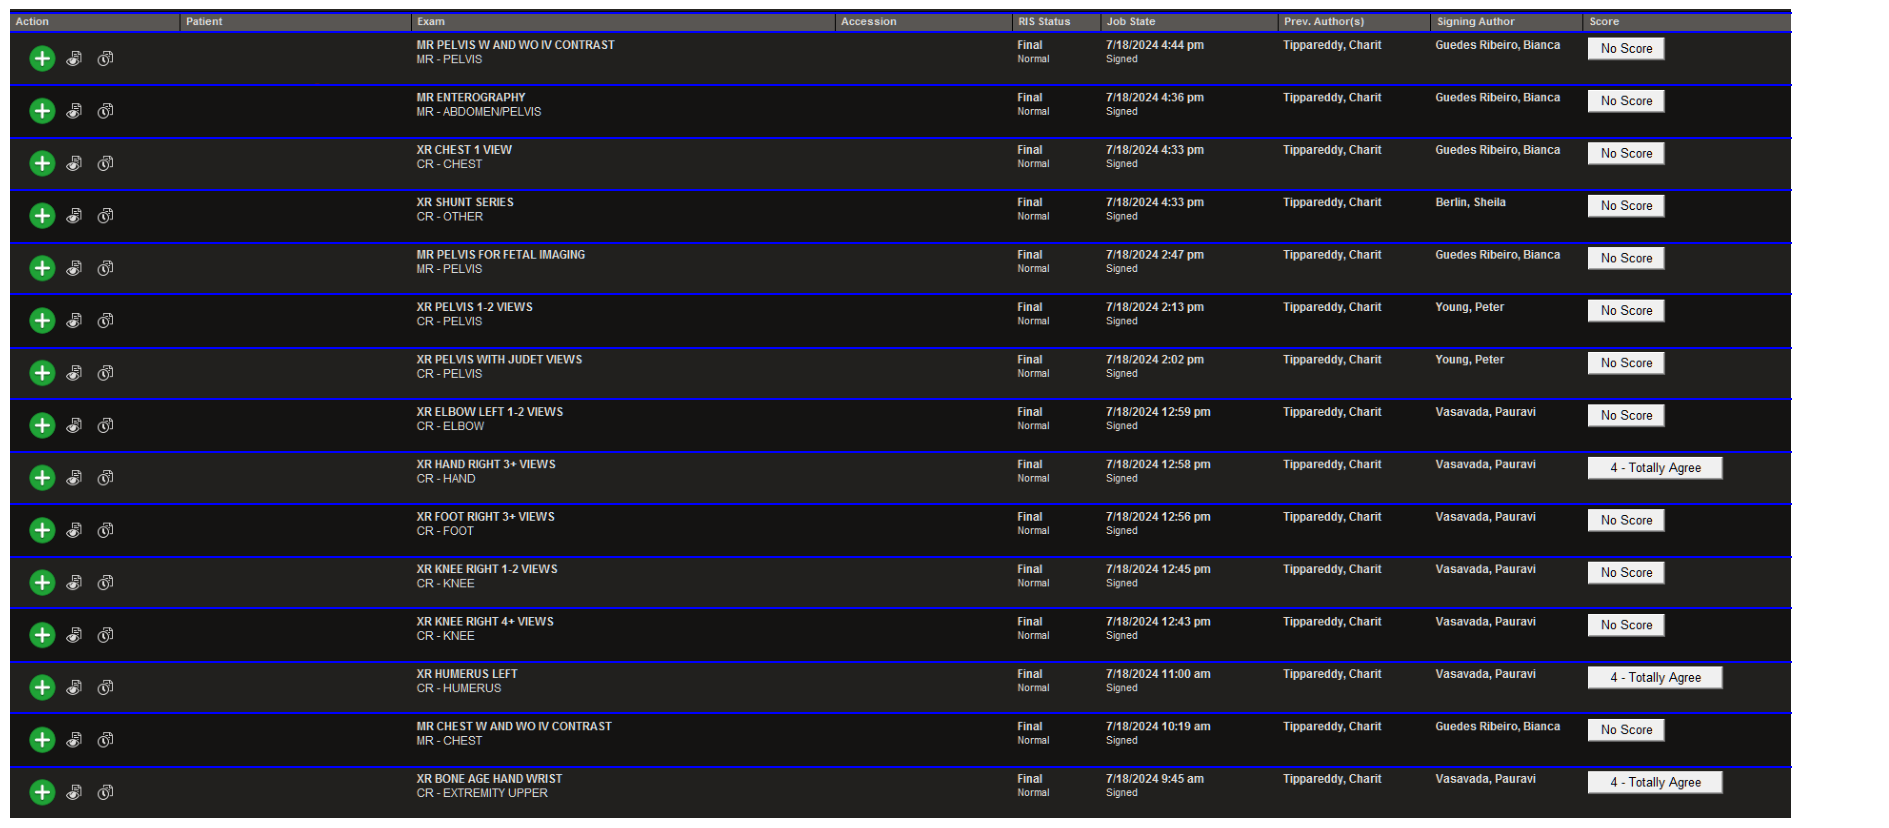

In [13]:
scroll_lines = cv.HoughLines(scroll_edges, 1, np.pi/180, 500)
scroll_lines = hough_to_cartesian(scroll_lines, scroll_area.shape, orientation='horizontal')
plot_matrix(scroll_area, "gray", lines=scroll_lines)

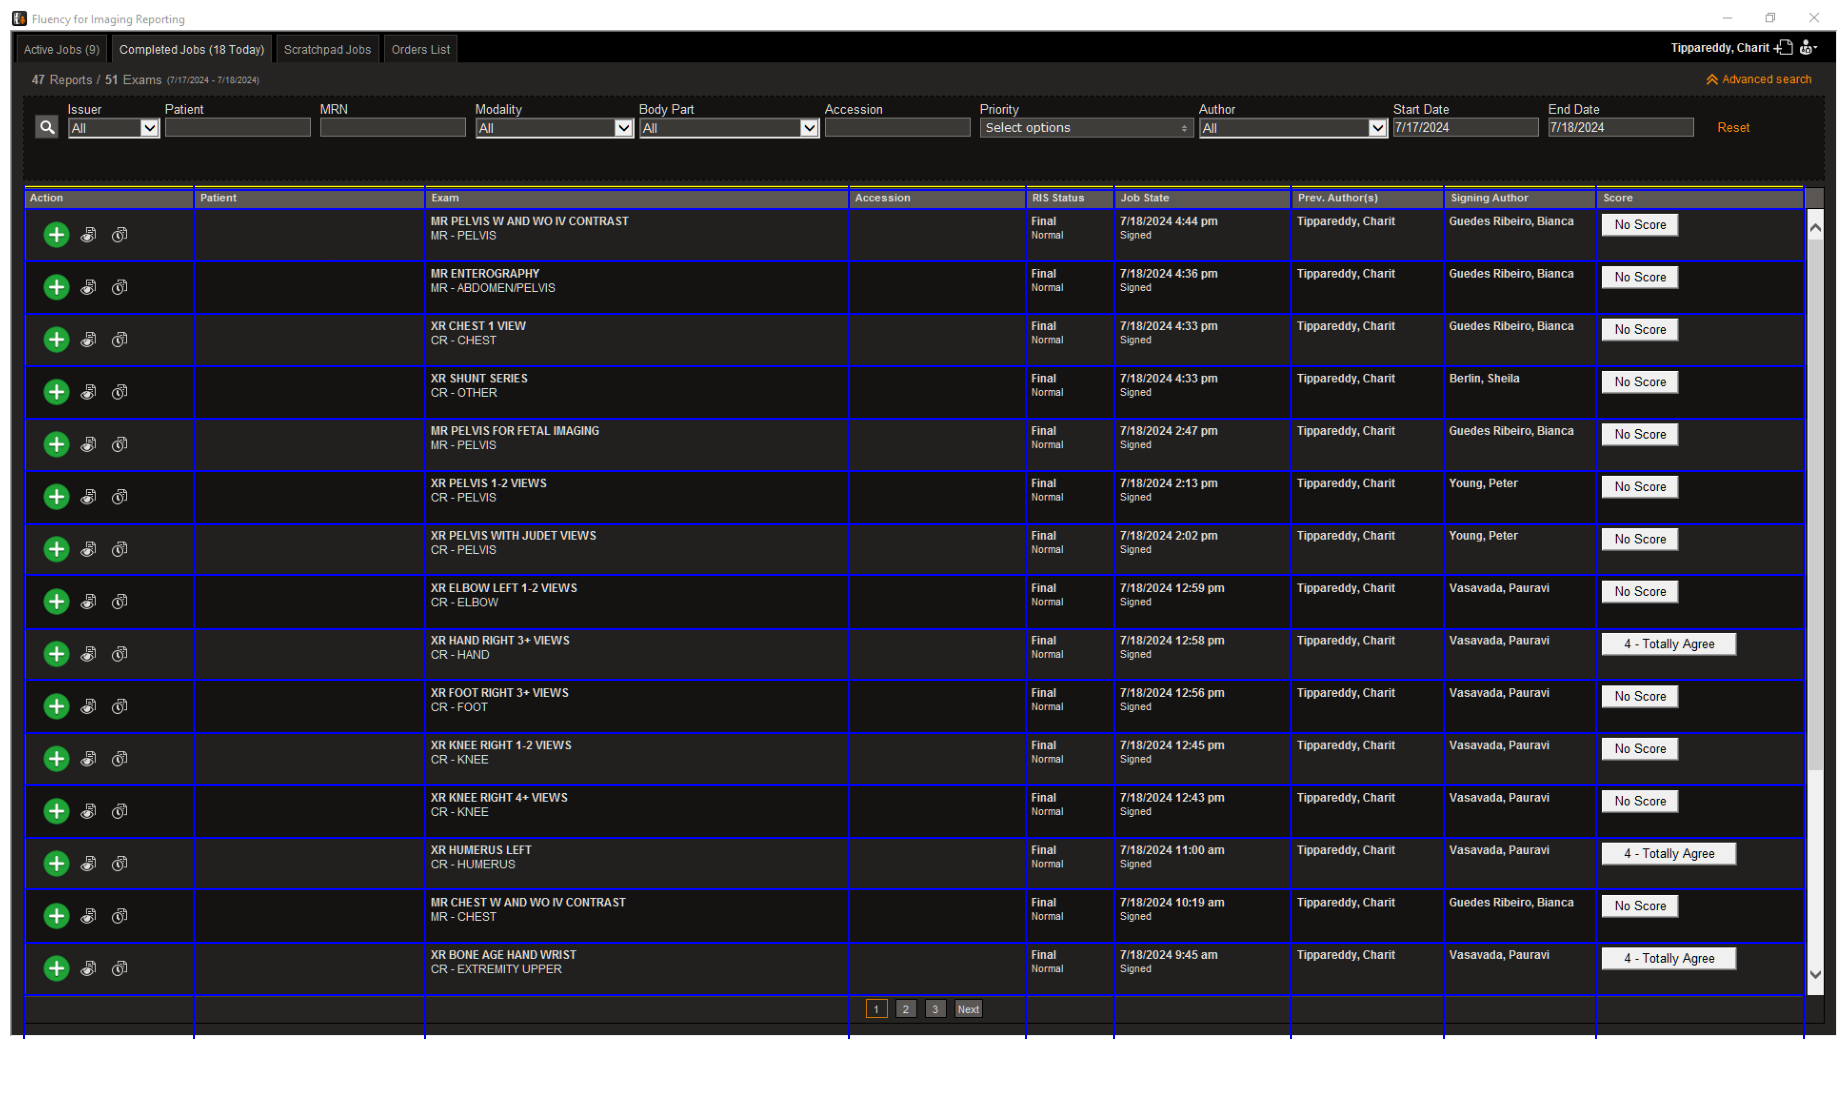

In [14]:
def find_rows(img, bounds):
    x, y, width, height = bounds
    area = img[y:y+height, x:x+width]
    edges = cv.Canny(area, 0, 50)
    lines = cv.HoughLines(edges, 1, np.pi/180, 500)
    lines = np.array(hough_to_cartesian(lines, area.shape, orientation='horizontal'))
    lines = lines + [x, y, x, y]

    last_line = lines[-1]
    scroll_lower_bound = np.array([x, y+height, x+width, y+height])
    if last_line[1] < scroll_lower_bound[1] - 10:
        lines = np.concatenate([lines, [scroll_lower_bound]])

    # ensure in sorted order from top row to bottom row
    lines = lines[lines[:, 1].argsort()]

    return lines

rows = find_rows(table, scroll_bounds)
columns = find_columns(table, header_bounds)
lines = np.concatenate([rows, columns])
plot_matrix(table, "gray", rect=[scroll_bounds], lines=lines)

### Recognizing Text Content of Cells with `WinOCR`

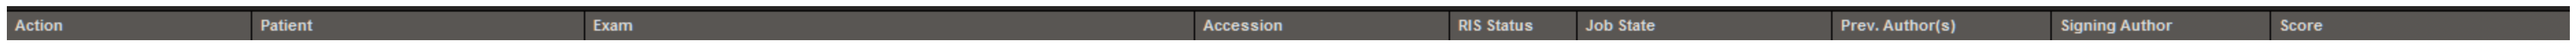

In [15]:
from winocr import recognize_cv2
x, y, width, height = header_bounds
header = table[y:y+height, x:x+width]
header_big = cv.resize(header, (0, 0), fx=2, fy=2)
plot_matrix(header_big, "gray")

Action 12.0 19.0 69.0 17.0
Patient 371.0 19.0 75.0 18.0
Exam 856.0 19.0 57.0 18.0
Accession 1745.0 19.0 117.0 18.0
RIS 2119.0 19.0 33.0 17.0
Status 2160.0 19.0 67.0 18.0
Job 2303.0 19.0 41.0 18.0
State 2352.0 19.0 54.0 18.0
Prev. 2677.0 19.0 55.0 18.0
Author(s) 2738.0 19.0 106.0 21.0
Signing 2998.0 19.0 80.0 21.0
Author 3084.0 19.0 77.0 17.0
Score 3318.0 19.0 62.0 18.0


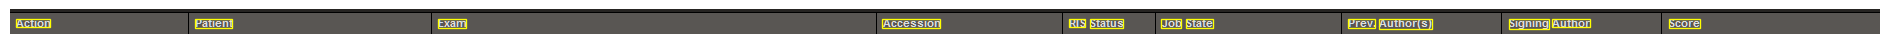

In [16]:
header_text = await recognize_cv2(header_big)
lines = header_text.lines
rects = []
for line in lines:
    for word in line.words:
        print(word.text, word.bounding_rect.x, word.bounding_rect.y, word.bounding_rect.width, word.bounding_rect.height)
        rects.append([
            word.bounding_rect.x // 2,
            word.bounding_rect.y // 2,
            word.bounding_rect.width // 2,
            word.bounding_rect.height // 2
        ])

plot_matrix(header, "gray", rect=rects)

In [17]:
header_text = await recognize_cv2(header_big)
lines = header_text.lines
words = []
rects = []
for line in lines:
    for word in line.words:
        words.append(word.text)
        rects.append([
            word.bounding_rect.x // 2,
            word.bounding_rect.y // 2,
            word.bounding_rect.width // 2,
            word.bounding_rect.height // 2
        ])

rects = np.array(rects) + np.array(header_bounds)
print(words)
print(rects)

['Action', 'Patient', 'Exam', 'Accession', 'RIS', 'Status', 'Job', 'State', 'Prev.', 'Author(s)', 'Signing', 'Author', 'Score']
[[  21.  194. 1904.   33.]
 [ 200.  194. 1907.   34.]
 [ 443.  194. 1898.   34.]
 [ 887.  194. 1928.   34.]
 [1074.  194. 1886.   33.]
 [1095.  194. 1903.   34.]
 [1166.  194. 1890.   34.]
 [1191.  194. 1897.   34.]
 [1353.  194. 1897.   34.]
 [1384.  194. 1923.   35.]
 [1514.  194. 1910.   35.]
 [1557.  194. 1908.   33.]
 [1674.  194. 1901.   34.]]


### Localizing the OCR Result to Sections of the Table

#### Header Row

In [18]:
def compute_intersections(rows, columns):
    """
    Compute intersections between two sets of lines representing columns and rows.
    
    Args:
        columns: numpy array of shape (n, 4) where each row is [x1, y1, x2, y2] representing vertical lines
        rows: numpy array of shape (m, 4) where each row is [x1, y1, x2, y2] representing horizontal lines
    
    Returns:
        intersections: numpy array of shape (m, n, 2) containing [x,y] coordinates of intersections
        where intersections[i,j,:] gives the [x,y] coordinates of the intersection of row i with column j
    """
    x_reshaped = columns[:, 0]
    y_reshaped = rows[:, 1]

    intersections = np.zeros((len(rows), len(columns), 2))
    intersections[:, :, 0] = x_reshaped[None, :]
    intersections[:, :, 1] = y_reshaped[:, None]

    return intersections

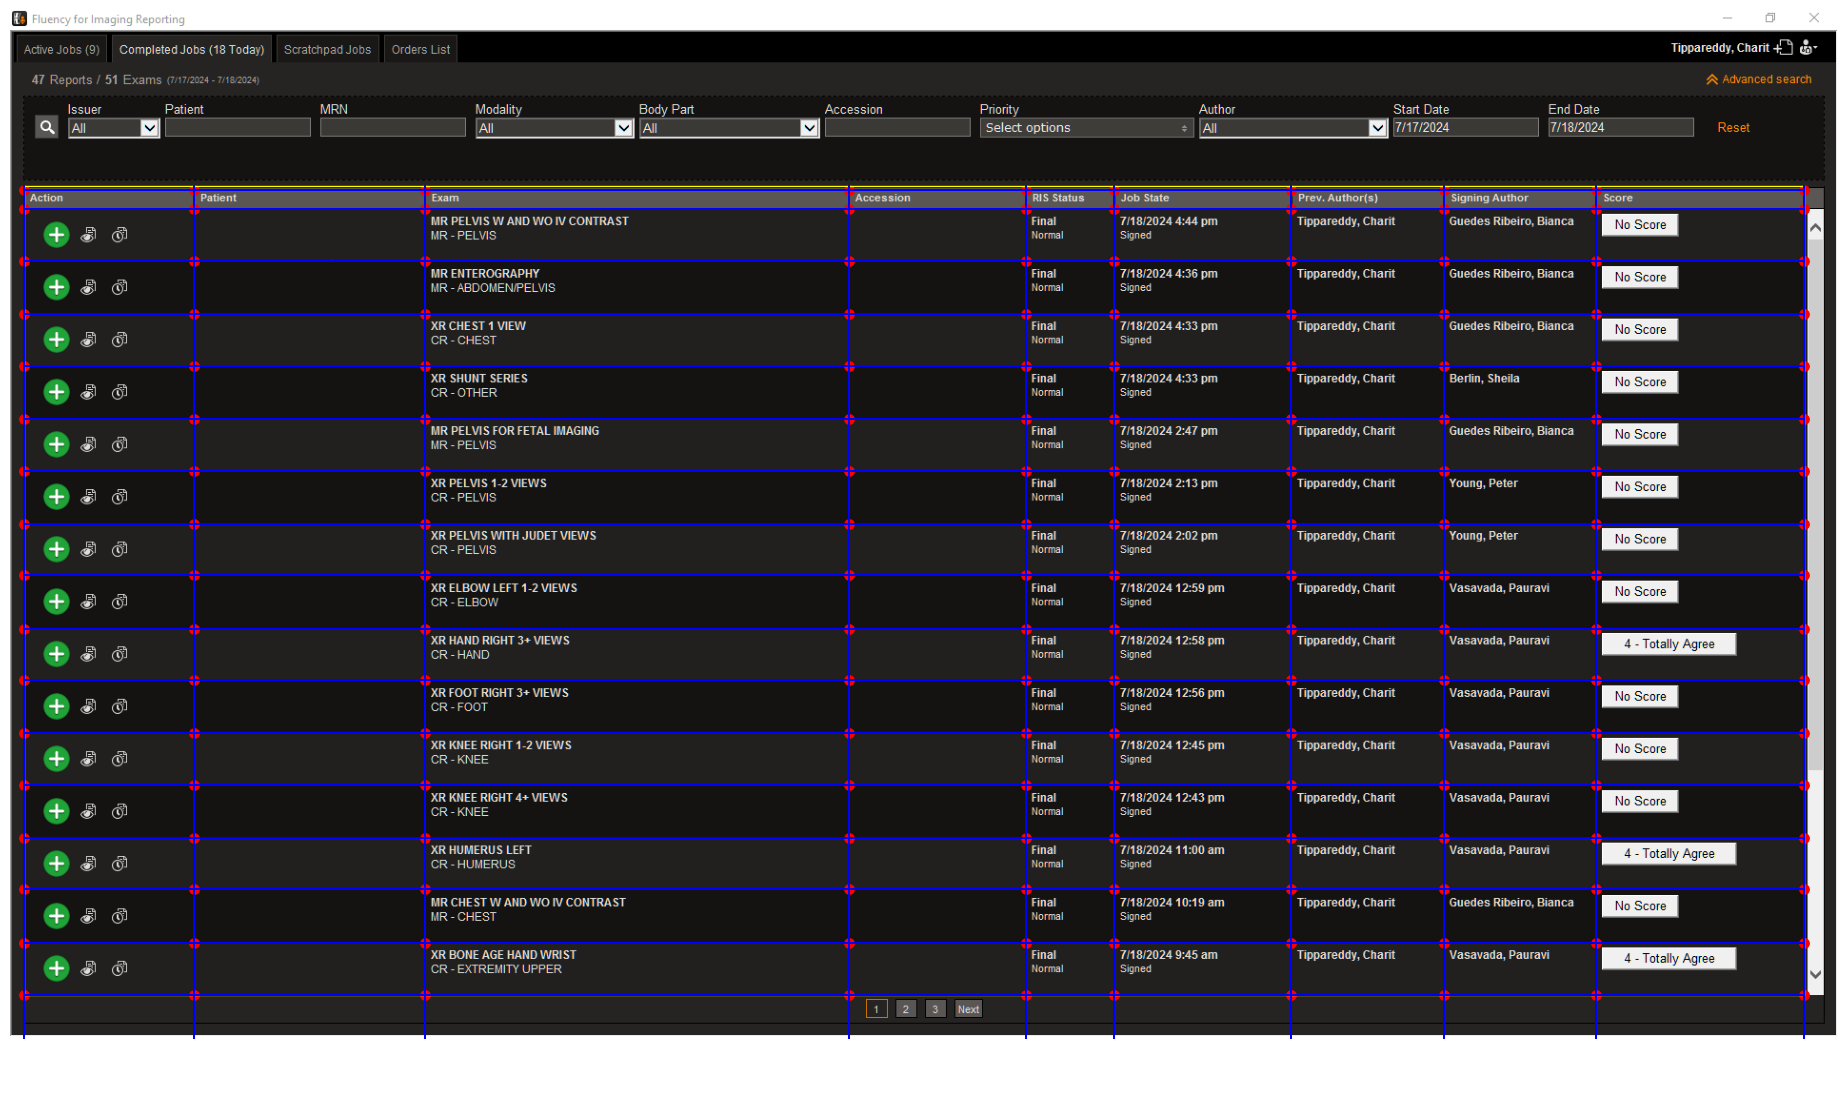

In [19]:
intersections = compute_intersections(rows, columns)
flattened = intersections.reshape(-1, 2)
plot_matrix(table, "gray", rect=[scroll_bounds], lines=np.concatenate([rows, columns]), points=flattened)

In [20]:
sample = rects[1, :2]
print(sample)
ff = intersections - sample[None, None, :]
top_left = (ff * np.array([-1, -1])).prod(axis=2)
flat_idx = np.where(top_left > 0, top_left, np.inf).argmin()
np.array(np.unravel_index(flat_idx, top_left.shape))

[200. 194.]


array([0, 1])

In [21]:
relrects = rects[:, :2]
ff = intersections[None, :, :, :] - relrects[:, None, None, :]
(ff * np.array([-1, -1])[None, None, None, :]).shape
top_left = (ff * np.array([-1, -1])).prod(axis=-1)
flat_idx = np.where(top_left > 0, top_left, np.inf).reshape(13, -1).argmin(axis=1)
coordinates = np.array(np.unravel_index(flat_idx, top_left.shape[1:])).T
coordinates

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 4],
       [0, 5],
       [0, 5],
       [0, 6],
       [0, 6],
       [0, 7],
       [0, 7],
       [0, 8]])

In [22]:
schema = {"index": None}
relcoords = coordinates[:, 1].flatten()
for i in range(len(columns) - 1):
    x = relcoords - i
    ii = np.where(x == 0)[0]
    colname = '_'.join(np.array(words)[ii])
    schema[colname] = {"data": None, "coordinate": None, "textstart": None}

schema

{'index': None,
 'Action': {'data': None, 'coordinate': None, 'textstart': None},
 'Patient': {'data': None, 'coordinate': None, 'textstart': None},
 'Exam': {'data': None, 'coordinate': None, 'textstart': None},
 'Accession': {'data': None, 'coordinate': None, 'textstart': None},
 'RIS_Status': {'data': None, 'coordinate': None, 'textstart': None},
 'Job_State': {'data': None, 'coordinate': None, 'textstart': None},
 'Prev._Author(s)': {'data': None, 'coordinate': None, 'textstart': None},
 'Signing_Author': {'data': None, 'coordinate': None, 'textstart': None},
 'Score': {'data': None, 'coordinate': None, 'textstart': None}}

#### Rest of Content

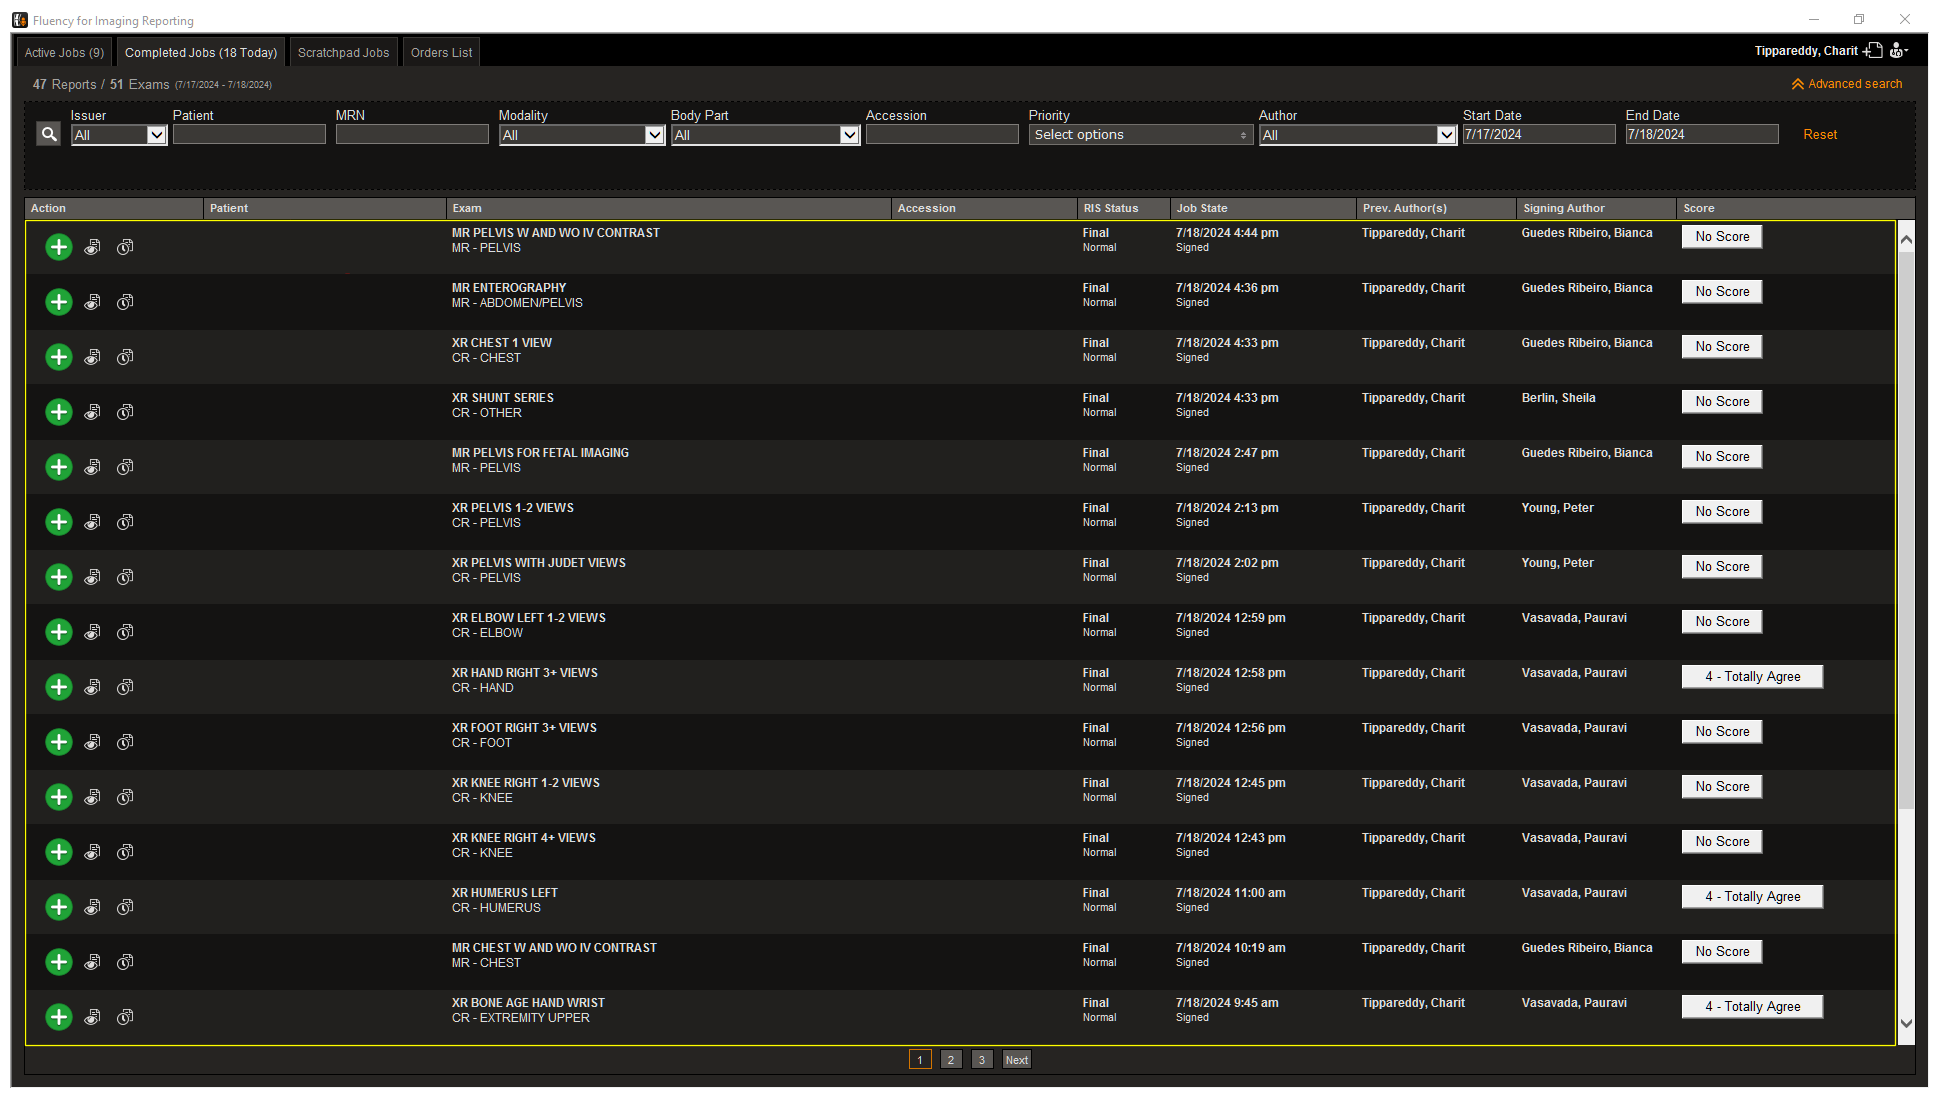

In [23]:
pure_table_bounds = (header_bounds[0], header_bounds[1] + header_bounds[3], scroll_bounds[2], scroll_bounds[3] - header_bounds[3])
pure_table_bounds

plot_matrix(table, "gray", rect=[pure_table_bounds])

In [24]:
x, y, width, height = pure_table_bounds
table_content = table[y:y+height, x:x+width]
ocr_result = await recognize_cv2(table_content)

content_words = []
content_rects = []
for line in ocr_result.lines:
    for word in line.words:
        content_words.append(word.text)
        content_rects.append([
            word.bounding_rect.x,
            word.bounding_rect.y,
            word.bounding_rect.width,
            word.bounding_rect.height
        ])

content_rects = np.array(content_rects) + np.array(pure_table_bounds)

In [25]:
content_sample = content_rects[11, :2]
smpff = intersections - content_sample[None, None, :]
smtop_left = (smpff * np.array([-1, -1])).prod(axis=2)
smflat_idx = np.where(smtop_left > 0, smtop_left, np.inf).argmin()
np.array(np.unravel_index(smflat_idx, smtop_left.shape))

array([2, 2])

In [26]:
conrelrects = content_rects[:, :2]
ff = intersections[None, :, :, :] - conrelrects[:, None, None, :]
top_left = (ff * np.array([-1, -1])[None, None, None, :]).prod(axis=-1)
flat_idx = np.where(top_left > 0, top_left, np.inf).reshape(len(content_words), -1).argmin(axis=1)
coordinates = np.array(np.unravel_index(flat_idx, top_left.shape[1:])).T

In [27]:
from copy import deepcopy

data = []
for i in range(len(rows) - 1):
    curr_row = deepcopy(schema)
    curr_row["index"] = i
    values = [[] for _ in range(1, len(schema.keys()))]
    intersection_point = [None for _ in range(1, len(schema.keys()))]
    textstart_point = [None for _ in range(1, len(schema.keys()))]
    row = np.where(coordinates[:, 0] == i)[0]
    for coord_idx in row:
        values_idx = coordinates[coord_idx, 1]
        values[values_idx].append(content_words[coord_idx])

        old_intersection_point = intersection_point[values_idx]
        update_ipoint = intersections[*coordinates[coord_idx]]
        intersection_point[values_idx] = update_ipoint if old_intersection_point is None else old_intersection_point


        old_textstart_point = textstart_point[values_idx]
        update_tpoint = content_rects[coord_idx, :2]
        textstart_point[values_idx] = update_tpoint if old_textstart_point is None else old_textstart_point

    values = [" ".join(v) for v in values]
    print(values, intersection_point, textstart_point)
    for key in list(schema.keys())[1:]:
        curr_row[key]["data"] = values.pop(0)
        curr_row[key]["coordinate"] = intersection_point.pop(0)
        curr_row[key]["textstart"] = textstart_point.pop(0)

    data.append(curr_row)

data

['', '', '', '', '', '', '', '', ''] [None, None, None, None, None, None, None, None, None] [None, None, None, None, None, None, None, None, None]
['', '', 'MR PELVIS W AND WO W CONTRAST MR - PELVIS', '', 'Final', '7/18/2024 4:44 pm', 'Tippareddy, Chant', 'Guedes Ribeiro, Bianca', 'No Score'] [None, None, array([436., 209.]), None, array([1067.,  209.]), array([1160.,  209.]), array([1346.,  209.]), array([1506.,  209.]), array([1666.,  209.])] [None, None, array([443., 219.]), None, array([1073.,  219.]), array([1166.,  219.]), array([1352.,  219.]), array([1512.,  219.]), array([1687.,  222.])]
['', '', 'MR ENTEROGRAPHY MR - ABDOMEN/PELVIS', '', 'Final', '7/18/2024 4:36 pm', 'Tippareddy, Chant', 'Guedes meiro, Bianca', 'No Score'] [None, None, array([436., 264.]), None, array([1067.,  264.]), array([1160.,  264.]), array([1346.,  264.]), array([1506.,  264.]), array([1666.,  264.])] [None, None, array([443., 274.]), None, array([1073.,  274.]), array([1166.,  274.]), array([1352.,  2

[{'index': 0,
  'Action': {'data': '', 'coordinate': None, 'textstart': None},
  'Patient': {'data': '', 'coordinate': None, 'textstart': None},
  'Exam': {'data': '', 'coordinate': None, 'textstart': None},
  'Accession': {'data': '', 'coordinate': None, 'textstart': None},
  'RIS_Status': {'data': '', 'coordinate': None, 'textstart': None},
  'Job_State': {'data': '', 'coordinate': None, 'textstart': None},
  'Prev._Author(s)': {'data': '', 'coordinate': None, 'textstart': None},
  'Signing_Author': {'data': '', 'coordinate': None, 'textstart': None},
  'Score': {'data': '', 'coordinate': None, 'textstart': None}},
 {'index': 1,
  'Action': {'data': '', 'coordinate': None, 'textstart': None},
  'Patient': {'data': '', 'coordinate': None, 'textstart': None},
  'Exam': {'data': 'MR PELVIS W AND WO W CONTRAST MR - PELVIS',
   'coordinate': array([436., 209.]),
   'textstart': array([443., 219.])},
  'Accession': {'data': '', 'coordinate': None, 'textstart': None},
  'RIS_Status': {'data

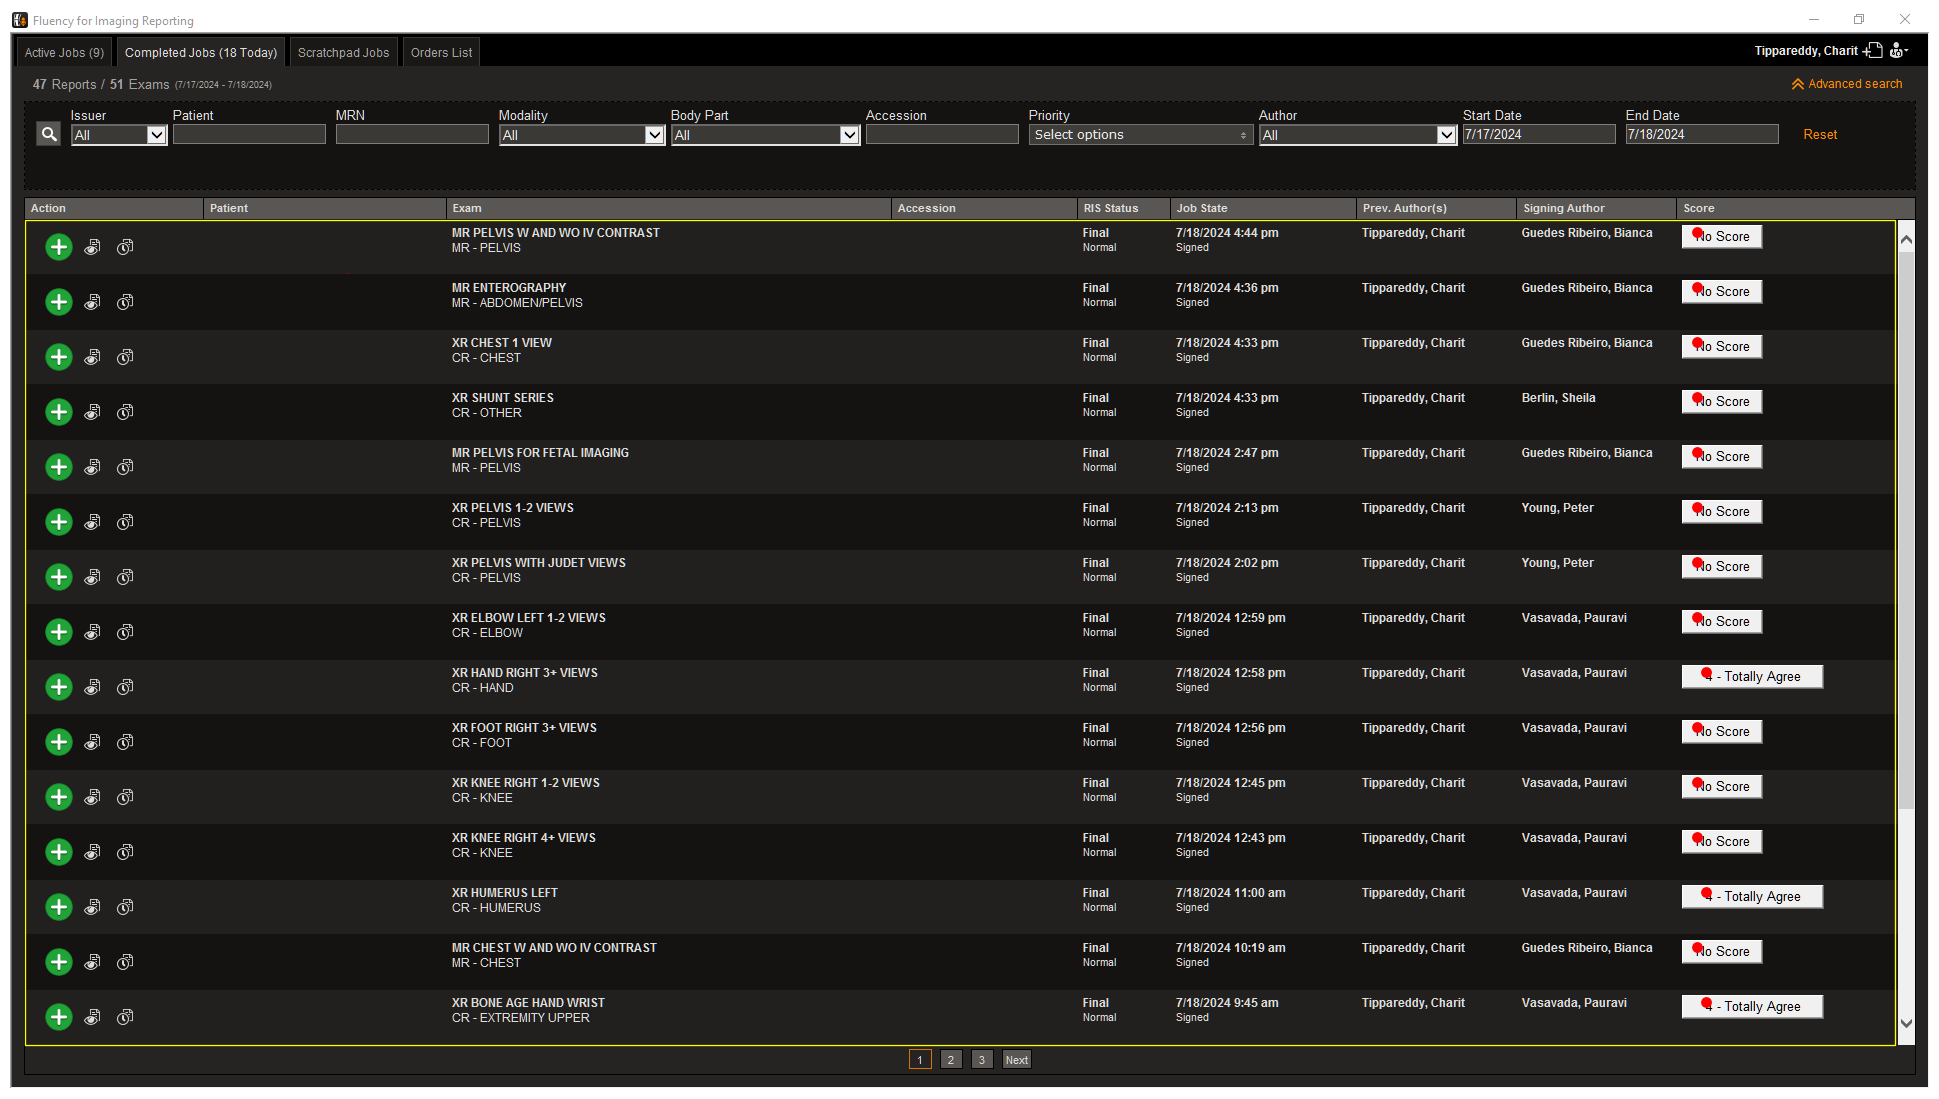

In [28]:
finalpts = [d["Score"]["textstart"] for d in data]
finalpts = np.array([p for p in finalpts if p is not None])
plot_matrix(table, "gray", rect=[pure_table_bounds], points=finalpts)

This all needs to be wrapped into a function or set of functions that takes the scroll area
and header as input and produces the output table - this list of dictionaries that we can then 
work with.

In [29]:
async def final_fantasy_table(table_img, scroll_bounds, header_bounds):
    # Get relevant regions
    scx, scy, sc_height, sc_width = scroll_bounds
    hx, hy, h_width, h_height = header_bounds
    header_area = table_img[hy:hy+h_height, hx:hx+h_width]

    # Get columns and rows
    columns = find_columns(table_img, header_bounds)
    rows = find_rows(table_img, scroll_bounds)
    intersections = compute_intersections(rows, columns)

    # Map to text
    expanded_header = cv.resize(header_area, (0, 0), fx=2, fy=2)
    header_text = await recognize_cv2(expanded_header)
    lines = header_text.lines
    words = []
    rects = []
    for line in lines:
        for word in line.words:
            words.append(word.text)
            rects.append([
                word.bounding_rect.x // 2,
                word.bounding_rect.y // 2,
                word.bounding_rect.width // 2,
                word.bounding_rect.height // 2
            ])
    rects = np.array(rects) + np.array(header_bounds)
    rects = rects[:, :2]
    t = intersections[None, :, :, :] - rects[:, None, None, :]
    tl = (t * np.array([-1, -1])[None, None, None, :]).prod(axis=-1)
    fidx = np.where(tl > 0, tl, np.inf).reshape(len(rects), -1).argmin(axis=1)
    hcoords = np.array(np.unravel_index(fidx, tl.shape[1:])).T

    schema = {"index": None, "state": {}}
    relcoords = hcoords[:, 1].flatten()
    for i in range(len(columns) - 1):
        x = relcoords - i
        ii = np.where(x == 0)[0]
        colname = "_".join(np.array(words)[ii])
        schema[colname] = {"data": None, "coordinate": None, "textstart": None}

    # Get content
    content_bounds = (
        header_bounds[0], 
        header_bounds[1] + header_bounds[3], 
        scroll_bounds[2], 
        scroll_bounds[3] - header_bounds[3]
    )
    cx, cy, cwidth, cheight = content_bounds
    table_content = table_img[cy:cy+cheight, cx:cx+cwidth]
    table_content_text = await recognize_cv2(table_content)
    content_words = []
    content_rects = []
    for line in table_content_text.lines:
        for word in line.words:
            content_words.append(word.text)
            content_rects.append([
                word.bounding_rect.x,
                word.bounding_rect.y,
                word.bounding_rect.width,
                word.bounding_rect.height
            ])

    content_rects = np.array(content_rects) + np.array(content_bounds)

    content_rects = content_rects[:, :2]
    ct = intersections[None, :, :, :] - content_rects[:, None, None, :]
    ctl = (ct * np.array([-1, -1])[None, None, None, :]).prod(axis=-1)
    cfidx = np.where(ctl > 0, ctl, np.inf).reshape(len(content_words), -1).argmin(axis=1)
    ccoords = np.array(np.unravel_index(cfidx, top_left.shape[1:])).T

    # Map content text to screen position
    data = []
    for i in range(len(rows) - 1):
        curr_row = deepcopy(schema)
        curr_row["index"] = i
        values = [[] for _ in range(1, len(schema.keys()))]
        intersection_point = [None for _ in range(2, len(schema.keys()))]  # index and state keys
        textstart_point = [None for _ in range(2, len(schema.keys()))]
        row = np.where(ccoords[:, 0] == i)[0]
        for coord_idx in row:
            values_idx = ccoords[coord_idx, 1]
            values[values_idx].append(content_words[coord_idx])

            old_intersection_point = intersection_point[values_idx]
            update_ipoint = intersections[*ccoords[coord_idx]]
            intersection_point[values_idx] = update_ipoint if old_intersection_point is None else old_intersection_point


            old_textstart_point = textstart_point[values_idx]
            update_tpoint = content_rects[coord_idx, :2]
            textstart_point[values_idx] = update_tpoint if old_textstart_point is None else old_textstart_point

        values = [" ".join(v) for v in values]
        for key in list(schema.keys())[2:]:  # index and state keys
            curr_row[key]["data"] = values.pop(0)
            curr_row[key]["coordinate"] = intersection_point.pop(0)
            curr_row[key]["textstart"] = textstart_point.pop(0)

        data.append(curr_row)

    return data


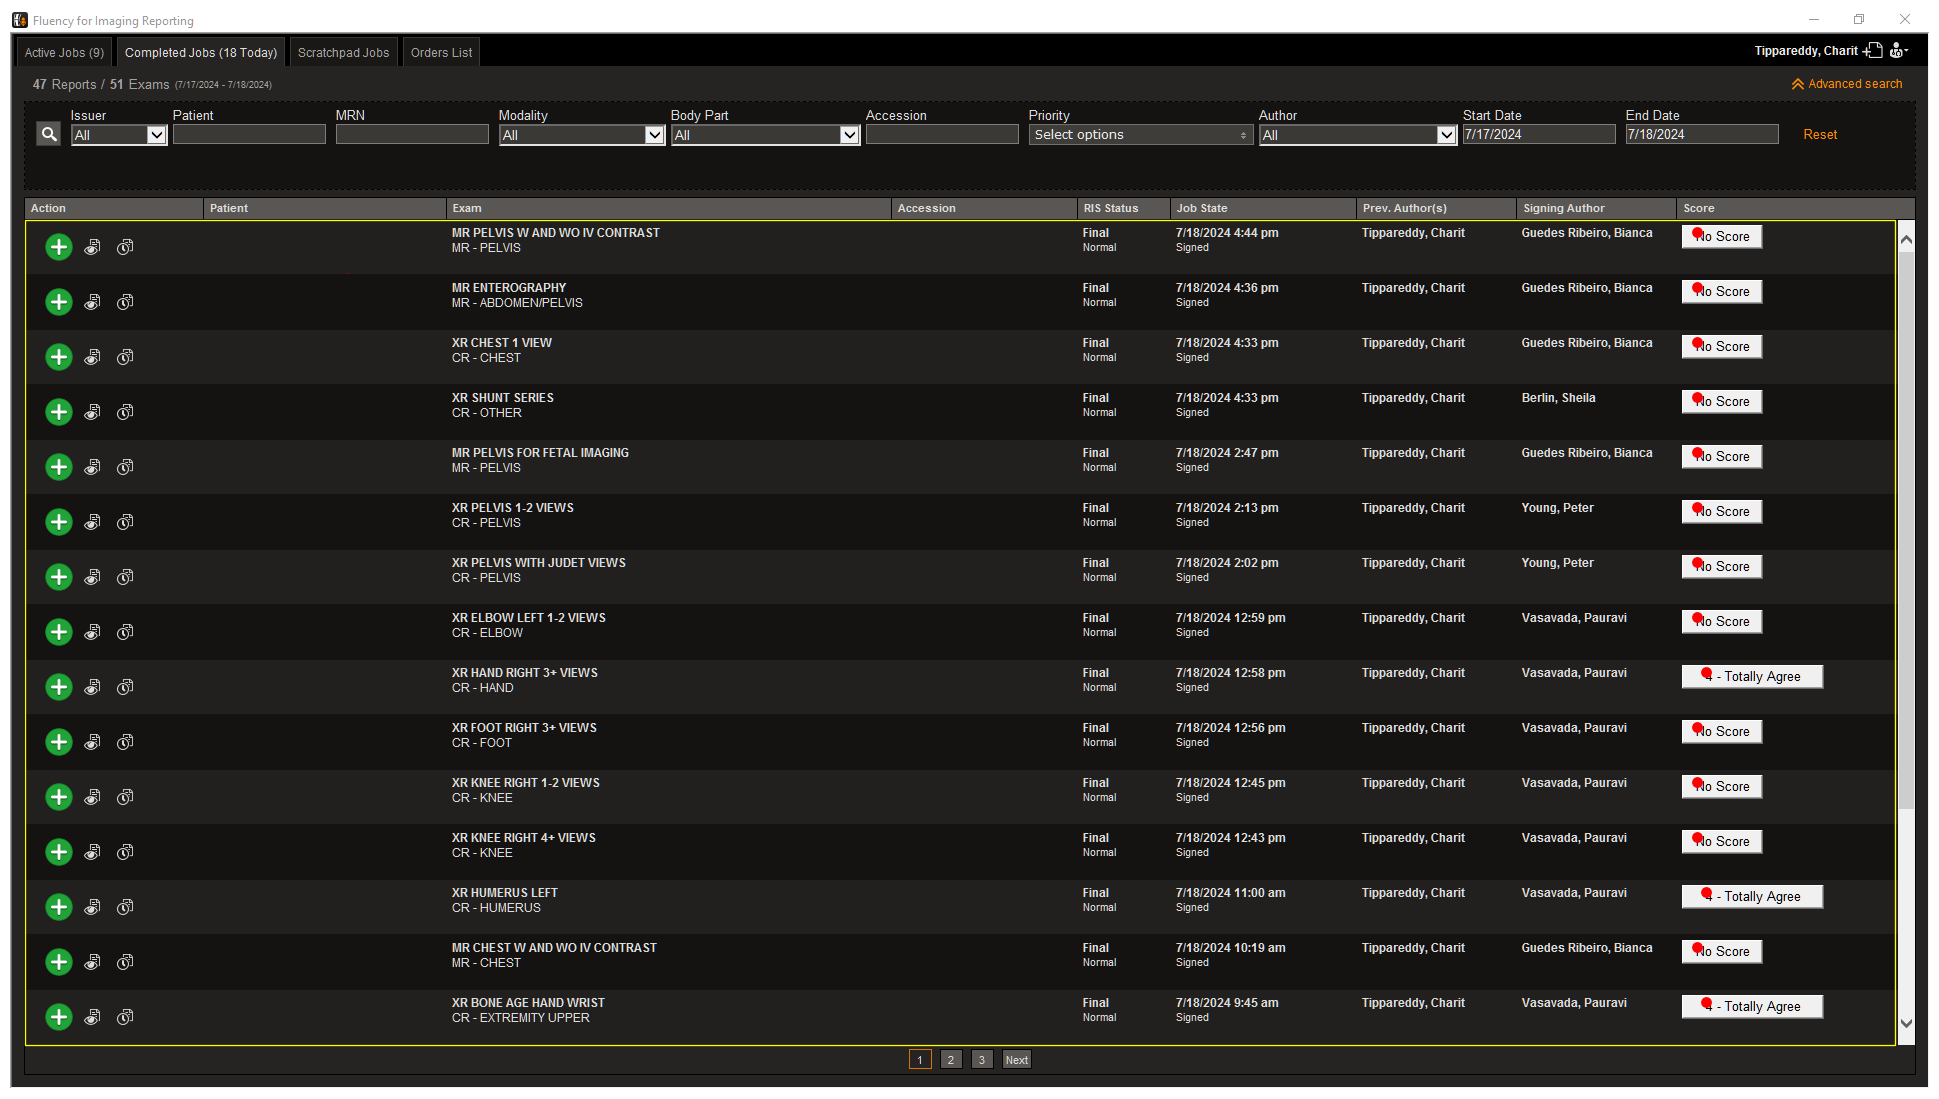

In [30]:
data = await final_fantasy_table(table, scroll_bounds, header_bounds)
finalpts = [d["Score"]["textstart"] for d in data]
finalpts = np.array([p for p in finalpts if p is not None])
plot_matrix(table, "gray", rect=[pure_table_bounds], points=finalpts)

In [31]:
data

[{'index': 0,
  'state': {},
  'Action': {'data': '', 'coordinate': None, 'textstart': None},
  'Patient': {'data': '', 'coordinate': None, 'textstart': None},
  'Exam': {'data': '', 'coordinate': None, 'textstart': None},
  'Accession': {'data': '', 'coordinate': None, 'textstart': None},
  'RIS_Status': {'data': '', 'coordinate': None, 'textstart': None},
  'Job_State': {'data': '', 'coordinate': None, 'textstart': None},
  'Prev._Author(s)': {'data': '', 'coordinate': None, 'textstart': None},
  'Signing_Author': {'data': '', 'coordinate': None, 'textstart': None},
  'Score': {'data': '', 'coordinate': None, 'textstart': None}},
 {'index': 1,
  'state': {},
  'Action': {'data': '', 'coordinate': None, 'textstart': None},
  'Patient': {'data': '', 'coordinate': None, 'textstart': None},
  'Exam': {'data': 'MR PELVIS W AND WO W CONTRAST MR - PELVIS',
   'coordinate': array([436., 209.]),
   'textstart': array([443., 219.])},
  'Accession': {'data': '', 'coordinate': None, 'textstart':

The function itself takes about a second to run (between 0.9 and 1.3 seconds by my testing), which is
feasible for doing this once every PgDn operation.